In [1]:
!pip install -q ../input/for-pydicom/pylibjpeg-1.4.0-py3-none-any.whl
!pip install -q ../input/for-pydicom/python_gdcm-3.0.14-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install -q ../input/for-pydicom/pylibjpeg_libjpeg-1.3.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

In [2]:
import os 
import pathlib
import glob 
from tqdm import tqdm 
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import pydicom

In [3]:
EPOCHS = 10
BATCH_SIZE = 16
IMAGE_SIZE = (512, 512)

In [4]:
DATA_DIR = "../input/rsna-2022-cervical-spine-fracture-detection/"
os.listdir(DATA_DIR)

['sample_submission.csv',
 'train_images',
 'train_bounding_boxes.csv',
 'segmentations',
 'train.csv',
 'test.csv',
 'test_images']

In [5]:
train_df = pd.read_csv(DATA_DIR + "train.csv")
train_df.head(10)

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0
5,1.2.826.0.1.3680043.4859,1,0,0,0,0,0,1,0
6,1.2.826.0.1.3680043.18659,1,0,0,0,1,0,0,1
7,1.2.826.0.1.3680043.17364,0,0,0,0,0,0,0,0
8,1.2.826.0.1.3680043.849,0,0,0,0,0,0,0,0
9,1.2.826.0.1.3680043.24045,1,0,0,0,0,0,0,1


In [6]:
os.listdir(DATA_DIR + "train_images")[:5]

['1.2.826.0.1.3680043.17625',
 '1.2.826.0.1.3680043.3850',
 '1.2.826.0.1.3680043.2286',
 '1.2.826.0.1.3680043.14435',
 '1.2.826.0.1.3680043.3442']

Podemos ver que en la carpeta de train hay varias carpetas con los ids de cada estudio y en cada carpeta hay subcarpetas con varios archivos dicom.

In [7]:
study_instance = "1.2.826.0.1.3680043.17625"
os.listdir(DATA_DIR + f"train_images/{study_instance}")[:5]

['12.dcm', '210.dcm', '120.dcm', '208.dcm', '141.dcm']

In [8]:
# select all the dicom files in the study instance
img_list = glob.glob(DATA_DIR + f"/train_images/{study_instance}/*.dcm")
len(img_list)

239

#### Funciones para cargar los datos dicom

In [9]:
def load_dicom(path):
    """
    reads a dicom file and loads the image array inside it
    inputs:
        path: the path of the required dicom file
    returns:
        data: image pixel arrays
    """
    img=pydicom.dcmread(path)
    data=img.pixel_array
    data=data-np.min(data)
    if np.max(data) != 0:
        data=data/np.max(data)
    data=(data*255).astype(np.uint8)
    return data

In [10]:
def data_generator():
    """
    a function that will load the dataset from a list of image paths
    """
    for path in img_list:
        data = load_dicom(path)
        yield data

In [11]:
train_dataset = tf.data.Dataset.from_generator(data_generator, (tf.uint8))

2022-11-18 08:06:52.672307: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 08:06:52.768615: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 08:06:52.769415: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 08:06:52.772272: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
for i in train_dataset.take(1):
    print(i.shape)
    print(type(i))

(512, 512)
<class 'tensorflow.python.framework.ops.EagerTensor'>


2022-11-18 08:06:55.563962: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [13]:
def show_single(img, cmap="gray"):
    """
    plots a single image
    """
    plt.imshow(img, cmap=cmap)
    plt.axis("off")

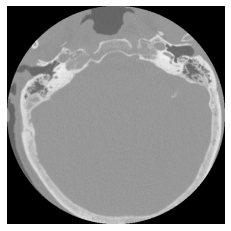

In [14]:
show_single(i)

In [15]:
def show_batch(cmap="gray"):
    """
    visualizes a batch of images
    """
    plt.figure(figsize=(16, 12))
    for i, img in enumerate(train_dataset.take(20)):  # iterate through the dataset
        plt.subplot(4, 5, i+1)
        show_single(img, cmap=cmap)
    plt.show()

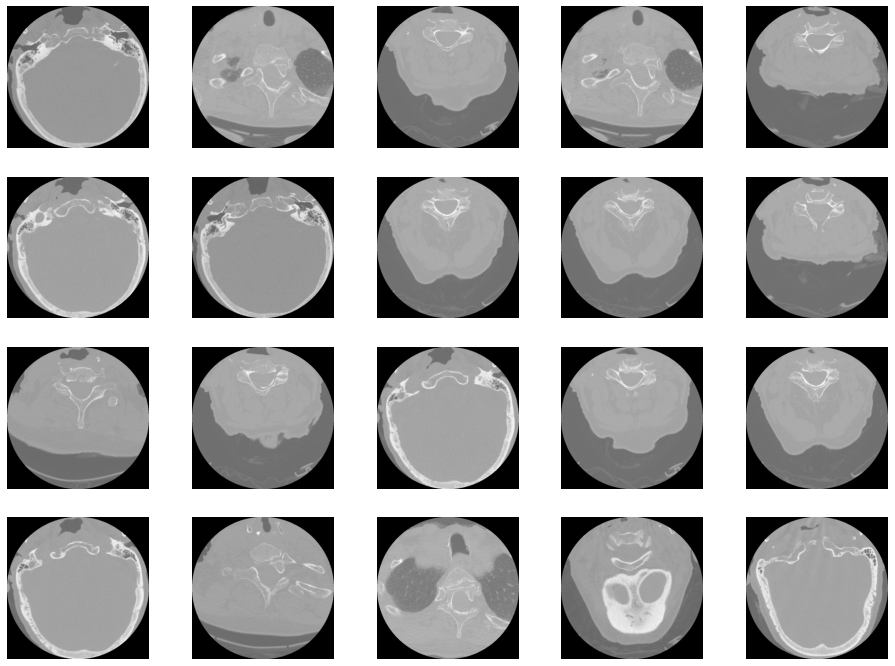

In [16]:
show_batch(cmap="gray")

In [17]:
def data_generator():
    for i, study_instance in enumerate(train_df.StudyInstanceUID[:3]):
        for dcm in os.listdir(DATA_DIR + f"train_images/{study_instance}"):
            train_labels = []
            path = DATA_DIR + f"train_images/{study_instance}/{dcm}"
            
            img = load_dicom(path)
            
#             resize each image into a shape of (512, 512)
            img = np.resize(img, IMAGE_SIZE)
#             img = cv2.resize(img, dsize=IMAGE_SIZE)
            #  normalize image
            img = img / 255.0
            # convert from gray scale to rgb, this will be helpful incase we want to use pretrained models
            img = tf.expand_dims(img, axis=-1)
            img = tf.image.grayscale_to_rgb(img)
            
            train_labels.extend([
                train_df.loc[i, "C1"],
                train_df.loc[i, "C2"],
                train_df.loc[i, "C3"],
                train_df.loc[i, "C4"],
                train_df.loc[i, "C5"],
                train_df.loc[i, "C6"],
                train_df.loc[i, "C7"],
                train_df.loc[i, "patient_overall"] # end with patient overall
            ])
            yield img, train_labels

In [18]:
train_data = tf.data.Dataset.from_generator(data_generator, (tf.float32, tf.int8))

In [19]:
for img, label in train_data.take(1):
    print(img.shape)
    print(label.shape)
    print(label)

(512, 512, 3)
(8,)
tf.Tensor([1 1 0 0 0 0 0 1], shape=(8,), dtype=int8)


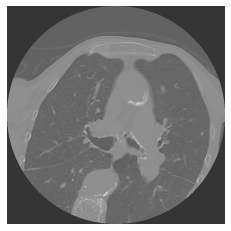

In [20]:
show_single(img, cmap="gray")

#### Preparando los datos para entrenamiento

In [21]:
img_count = 0
for _, _ in enumerate(train_df.StudyInstanceUID[:3]):
    for _ in os.listdir(DATA_DIR + f"train_images/{study_instance}"):
        img_count += 1
print(img_count)

717


In [22]:
val_size = int(img_count * 0.2)
train_data = train_data.skip(val_size)
val_data = train_data.take(val_size)

In [23]:
def configure_for_performance(data):
    data = data.cache()
#     data = data.shuffle(buffer_size=300)
    data = data.batch(16)
    data = data.prefetch(buffer_size=tf.data.AUTOTUNE)
    return data

In [24]:
train_data = configure_for_performance(train_data)
val_data = configure_for_performance(val_data)

#### Creacion del Modelo

In [25]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, Flatten

In [26]:
# Define Alex Net model
def alex_net():
    model = Sequential()

    # 1st Convolutional Layer
    model.add(Conv2D(filters=96, input_shape=(*IMAGE_SIZE, 3), kernel_size=(11,11),\
     strides=(4,4), padding='valid', activation="relu"))
    # Pooling 
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # 2nd Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid', activation="relu"))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 3rd Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', activation="relu"))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 4th Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', activation="relu"))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 5th Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid', activation="relu"))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Passing it to a dense layer
    model.add(Flatten())
    # 1st Dense Layer
    model.add(Dense(4096, input_shape=(IMAGE_SIZE[0]*IMAGE_SIZE[1]*3,), activation="relu"))
    # Add Dropout to prevent overfitting
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 2nd Dense Layer
    model.add(Dense(4096, activation="relu"))
    # Add Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 3rd Dense Layer
    model.add(Dense(1000, activation="relu"))
    # Add Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Output Layer with 8 probability classes
    model.add(Dense(8, activation="softmax"))
    return model

In [27]:
model = alex_net()

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 96)      34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 256)       2973952   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 256)       1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 384)       8

In [29]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()]
             )

In [30]:
history = model.fit(train_data, validation_data=val_data,
                   epochs=50)

Epoch 1/50


2022-11-18 08:07:06.011143: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


56/56 [==============================] - 44s 541ms/step - loss: 4.9570 - categorical_accuracy: 0.2290 - val_loss: 42.8891 - val_categorical_accuracy: 0.0000e+00
Epoch 2/50
56/56 [==============================] - 4s 77ms/step - loss: 2.9632 - categorical_accuracy: 0.4063 - val_loss: 6.0140 - val_categorical_accuracy: 0.0420
Epoch 3/50
56/56 [==============================] - 4s 77ms/step - loss: 2.3979 - categorical_accuracy: 0.4097 - val_loss: 6.1846 - val_categorical_accuracy: 0.0839
Epoch 4/50
56/56 [==============================] - 4s 77ms/step - loss: 2.2209 - categorical_accuracy: 0.4433 - val_loss: 5.4954 - val_categorical_accuracy: 0.0699
Epoch 5/50
56/56 [==============================] - 4s 77ms/step - loss: 2.1171 - categorical_accuracy: 0.4355 - val_loss: 4.2330 - val_categorical_accuracy: 0.2867
Epoch 6/50
56/56 [==============================] - 4s 78ms/step - loss: 2.0545 - categorical_accuracy: 0.4299 - val_loss: 5.1630 - val_categorical_accuracy: 0.0140
Epoch 7/50
56/

In [31]:
# visualize training 
def viz_loss(history):
    train_loss = history["loss"]
    val_loss = history["val_loss"]
    iters = [i for i in range(EPOCHS)]
    
    plt.plot(iters, train_loss, label="Training Loss")
    plt.plot(iters, val_loss, label="Validation Loss")
    plt.title("A plot of Loss against number of iterations")
    plt.legend()
    plt.show()
    
def viz_acc(history):
    train_loss = history["categorical_accuracy"]
    val_loss = history["val_categorical_accuracy"]
    iters = [i for i in range(EPOCHS)]
    
    plt.plot(iters, train_loss, label="Training Accuracy")
    plt.plot(iters, val_loss, label="Validation Accuracy")
    plt.title("A plot of Accuracy against number of iterations")
    plt.legend()
    plt.show()

In [ ]:
viz_loss(history.history)
viz_acc(history.history)

In [34]:
test_df = pd.read_csv(DATA_DIR + "test.csv")
test_df.head()

,row_id,StudyInstanceUID,prediction_type
0,1.2.826.0.1.3680043.10197_C1,1.2.826.0.1.3680043.10197,C1
1,1.2.826.0.1.3680043.10454_C1,1.2.826.0.1.3680043.10454,C1
2,1.2.826.0.1.3680043.10690_C1,1.2.826.0.1.3680043.10690,C1


In [35]:
global test_ids
test_ids = []
def test_data_generator():
    for study_instance in os.listdir(DATA_DIR + f"test_images"):
        for dcm in os.listdir(DATA_DIR + f"test_images/{study_instance}"):
            path = DATA_DIR + f"test_images/{study_instance}/{dcm}"
            img = load_dicom(path)
            
            # resize each image into a shape of (512, 512)
            img = np.resize(img, IMAGE_SIZE)
            #  normalize image
            img = tf.cast(img, tf.float32) / 255.0
            # convert from gray scale to rgb, this will be helpful incase we want to use pretrained models
            img = tf.expand_dims(img, axis=-1)
            img = tf.image.grayscale_to_rgb(img)
            test_ids.append(study_instance)
            yield img

In [36]:
test_data = tf.data.Dataset.from_generator(test_data_generator, tf.float32).batch(1)

In [37]:
# make predictions
preds = []
for img in tqdm(test_data):
    preds.append(model.predict(img)[0])
preds = np.array(preds)

1318it [01:28, 14.92it/s]


In [38]:
assert len(test_ids) == len(preds)

In [39]:
result = pd.DataFrame(columns = ["StudyInstanceUID", 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'patient_overall'])

In [40]:
for i in tqdm(range(len(test_ids))):
    result.loc[i, 'StudyInstanceUID'] = test_ids[i]
    rows = preds[i].round(3)
    result.loc[i, 'C1'] = rows[0]
    result.loc[i, 'C2'] = rows[1]
    result.loc[i, 'C3'] = rows[2]
    result.loc[i, 'C4'] = rows[3]
    result.loc[i, 'C5'] = rows[4]
    result.loc[i, 'C6'] = rows[5]
    result.loc[i, 'C7'] = rows[6]
    result.loc[i, 'patient_overall'] = rows[7]

100%|██████████| 1318/1318 [00:01<00:00, 999.09it/s]


In [41]:
result.head()

,StudyInstanceUID,C1,C2,C3,C4,C5,C6,C7,patient_overall
0,1.2.826.0.1.3680043.22327,0.036,0.48,0.0,0.0,0.0,0.0,0.0,0.482
1,1.2.826.0.1.3680043.22327,0.03,0.484,0.0,0.0,0.0,0.0,0.0,0.486
2,1.2.826.0.1.3680043.22327,0.032,0.485,0.0,0.0,0.0,0.0,0.0,0.483
3,1.2.826.0.1.3680043.22327,0.053,0.472,0.0,0.001,0.0,0.0,0.001,0.473
4,1.2.826.0.1.3680043.22327,0.039,0.479,0.0,0.0,0.0,0.0,0.0,0.481


In [42]:
means = result[['patient_overall', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].mean().to_dict()
print(means)

{'patient_overall': 0.4799298067917773, 'C1': 0.02372456465216074, 'C2': 0.4959887676788932, 'C3': 2.9590280446731267e-05, 'C4': 6.525037592568057e-05, 'C5': 2.3520488026290453e-05, 'C6': 2.048558616312574e-05, 'C7': 6.904400466787255e-05}


In [43]:
model.save('model.h5')